pproach 3:Images with original sizes using histogram

*1000 imagens rotuladas manualmente no LabelImg (NRG: 573 e RG: 427) \
*Imagens sem nenhuma alteração nas dimensões, identicas ao dataset AIROGS, sendo assim com dimensões variadas. \
*Técnica de processamento: Equalização de histograma\
*10000 épocas\


*Métricas \


Recall (TPR): 0.88\
Precision (PPV): 0.80\
Specificity (TNR): 0.84\
Accuracy (ACC): 0.86\
F1 score (F1): 0.8409


In [ ]:
pip install torch-snippets

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import PIL
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torch_snippets import Report
import os
import time
import xml.etree.ElementTree as ET
# Connect to the GPU if one exists.
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/ProjetoGlaucoma/originais_.zip


In [ ]:
import os
import pandas as pd
import xml.etree.ElementTree as ET

# Ler tabela de labels
labels_df = pd.read_csv('/content/drive/MyDrive/ProjetoGlaucoma/labels.csv')


# Iterar sobre arquivos XML na pasta de anotações
annotations_dir = './annotations'
all_correct = True
for xml_file in os.listdir(annotations_dir):
    # Verificar se o arquivo é um arquivo XML
    if xml_file.endswith('.xml'):
        # Abrir arquivo XML e encontrar valor da tag <name>
        tree = ET.parse(os.path.join(annotations_dir, xml_file))
        root = tree.getroot()
        name = root.find('object/name').text
        
        # Procurar o valor correspondente na tabela de labels
        label = labels_df.loc[labels_df['challenge_id'] == xml_file[:-4], 'class'].iloc[0]
        
        # Verificar se os valores são idênticos
        if name != label:
            all_correct = False
            print(f"Anotação incorreta no arquivo {xml_file}")
            break

if all_correct:
    print("Todas as anotações estão corretas")


Todas as anotações estão corretas


In [ ]:
import glob
from skimage import io, exposure
import os

# Obter a lista de caminhos dos arquivos de imagem na pasta "./images"
image_paths = glob.glob("./images/*.jpg")

for image_path in image_paths:
    # Carregar a imagem
    image = io.imread(image_path)

    # Aplicar a normalização de contraste
    image = exposure.equalize_hist(image)

    # Obter o nome do arquivo
    file_name = os.path.basename(image_path)

    # Construir o caminho de salvamento da imagem
    save_path = os.path.join("./images", file_name)

    # Salvar a imagem com o mesmo nome na mesma pasta
    io.imsave(save_path, image)

In [ ]:
def xml_to_dict(xml_path):
    # Decode the .xml file
    tree = ET.parse(xml_path)
    root = tree.getroot()
    # Get the filename from the path
    filename = os.path.splitext(os.path.basename(xml_path))[0]
    # Return the image size, object label and bounding box 
    # coordinates together with the filename as a dict.
    return {"filename": filename,
            "image_width": int(root.find("./size/width").text),
            "image_height": int(root.find("./size/height").text),
            "image_channels": int(root.find("./size/depth").text),
            "label": root.find("./object/name").text,
            "x1": int(root.find("./object/bndbox/xmin").text),
            "y1": int(root.find("./object/bndbox/ymin").text),
            "x2": int(root.find("./object/bndbox/xmax").text),
            "y2": int(root.find("./object/bndbox/ymax").text)}

In [ ]:
#O modelo  faz previsões para o background  como classe 0 por padrão, por isso "NRG": 2
label_dict = {"NRG": 2, "RG": 1}
reverse_label_dict = {1: "RG", 2: "NRG"}

In [ ]:
import os
import pandas as pd
import torch
import torchvision.transforms as T
import PIL

labels_df = pd.read_csv("/content/drive/MyDrive/ProjetoDeteccaoGlaucoma/labels.csv")
image_dir = "./images"

class GlaucomaDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        """
        Inputs
            root: str
                Path to the data folder.
            transforms: Compose or list
                Torchvision image transformations.
        """
        self.root = root
        self.transforms = transforms
        self.files = sorted(os.listdir("./images"))
        for i in range(len(self.files)):
            self.files[i] = self.files[i].split(".")[0]
        self.label_dict = {"RG": 1, "NRG": 2}
        self.true_labels = []
        for i in range(len(labels_df)):
            image_name = labels_df.iloc[i]["challenge_id"]
            label = labels_df.iloc[i]["class"]
            if os.path.isfile(os.path.join(image_dir, f"{image_name}.jpg")):
                image_id = self.files.index(image_name)
                self.true_labels.append({"name_image": image_name,
                                         "image_id": image_id,
                                         "label": self.label_dict[label]})

    def __getitem__(self, i):
        # Load image from the hard disc.
        
        img = PIL.Image.open(os.path.join(self.root, 
              "images/" + self.files[i] + ".jpg")).convert("RGB")
        ann = xml_to_dict(os.path.join(self.root, 
              "annotations/" + self.files[i] + ".xml"))
        
        # The target is given as a dict.
        target = {}
        target["boxes"] = torch.as_tensor([[ann["x1"], 
                                            ann["y1"], 
                                            ann["x2"], 
                                            ann["y2"]]], 
                                   dtype = torch.float32)
        target["labels"]=torch.as_tensor([label_dict[ann["label"]]],
                         dtype = torch.int64)
       
        
        target["image_id"] = torch.as_tensor([i], dtype = torch. torch.int64)

        # Apply any transforms to the data if required.
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        
        return img, target
    
    def __len__(self):
        return len(self.files)
    
def get_true_labels(dataset):
    """
    Inputs
        dataset: GlaucomaDataset
            Dataset containing the true labels.
    """
    true_labels_list = []
    for item in dataset.true_labels:
        true_labels_list.append({"name_image": item['name_image'], "image_id": item['image_id'], "label": item['label']})
    return true_labels_list


In [ ]:



dataset = GlaucomaDataset(root=".", transforms=None)
true_labels = get_true_labels(dataset)

print("True labels:")
for item in true_labels:
    print(f"Image name: {item['name_image']}, Image id: {item['image_id']}, Label: {item['label']}")


# Contagem das labels
rg_count = 0
nrg_count = 0

# Iterar sobre as verdadeiras labels
for item in true_labels:
    if item['label'] == 1:
        rg_count += 1
    elif item['label'] == 2:
        nrg_count += 1

# Imprimir os resultados
print("Quantidade de labels RG:", rg_count)
print("Quantidade de labels NRG:", nrg_count)



True labels:
Image name: TRAIN000034, Image id: 0, Label: 1
Image name: TRAIN000035, Image id: 1, Label: 2
Image name: TRAIN000061, Image id: 2, Label: 2
Image name: TRAIN000068, Image id: 3, Label: 1
Image name: TRAIN000069, Image id: 4, Label: 2
Image name: TRAIN000100, Image id: 5, Label: 1
Image name: TRAIN000101, Image id: 6, Label: 2
Image name: TRAIN000106, Image id: 7, Label: 1
Image name: TRAIN000107, Image id: 8, Label: 2
Image name: TRAIN000123, Image id: 9, Label: 2
Image name: TRAIN000128, Image id: 10, Label: 2
Image name: TRAIN000140, Image id: 11, Label: 1
Image name: TRAIN000141, Image id: 12, Label: 2
Image name: TRAIN000188, Image id: 13, Label: 1
Image name: TRAIN000189, Image id: 14, Label: 2
Image name: TRAIN000195, Image id: 15, Label: 1
Image name: TRAIN000196, Image id: 16, Label: 2
Image name: TRAIN000225, Image id: 17, Label: 1
Image name: TRAIN000226, Image id: 18, Label: 2
Image name: TRAIN000286, Image id: 19, Label: 2
Image name: TRAIN000330, Image id: 20

In [ ]:
import torchvision.transforms.functional as F
import torchvision.transforms.transforms as T
class Compose:
    """
    Composes several torchvision image transforms 
    as a sequence of transformations.
    Inputs
        transforms: list
            List of torchvision image transformations.
    Returns
        image: tensor
        target: dict
    """
    def __init__(self, transforms = []):
        self.transforms = transforms
    # __call__ sequentially performs the image transformations on
    # the input image, and returns the augmented image.
    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

In [ ]:

class ToTensor(torch.nn.Module):
    """
    Converts a PIL image into a torch tensor.
    Inputs
        image: PIL Image
        target: dict
    Returns
        image: tensor
        target: dict
    """
    def forward(self, image, target = None):
        image = F.pil_to_tensor(image)
        image = F.convert_image_dtype(image)
        return image, target
class RandomHorizontalFlip(T.RandomHorizontalFlip):
    """
    Randomly flips an image horizontally.
    Inputs
        image: tensor
        target: dict
    Returns
        image: tensor
        target: dict
    """
    def forward(self, image, target = None):
        if torch.rand(1) < self.p:
            image = F.hflip(image)
            if target is not None:
                width, _ = F.get_image_size(image)
                target["boxes"][:, [0, 2]] = width - \
                                     target["boxes"][:, [2, 0]]
        return image, target

In [ ]:
def get_transform(train):
    """
    Transforms a PIL Image into a torch tensor, and performs
    random horizontal flipping of the image if training a model.
    Inputs
        train: bool
            Flag indicating whether model training will occur.
    Returns
        compose: Compose
            Composition of image transforms.
    """
    transforms = []
    # ToTensor is applied to all images.
    transforms.append(ToTensor())
    # The following transforms are applied only to the train set.
    if train == True:
        transforms.append(RandomHorizontalFlip(0.5))
        # Other transforms can be added here later on.
    return Compose(transforms)

In [ ]:
# Train dataset.
# Test dataset.
test_ds = GlaucomaDataset("./", get_transform(train=False))
# Set train = True to apply the training image transforms.
train_ds = GlaucomaDataset("./", get_transform(train=True))
# Validation dataset.
val_ds = GlaucomaDataset("./", get_transform(train=False))



In [ ]:
"""
    indices = list(range(len(train_ds)))
    test_size = int(len(indices) * 0.1)
    val_size = int(len(indices) * 0.2)

    test_indices = indices[:test_size]
    val_indices = indices[test_size:test_size+val_size]
    train_indices = indices[test_size+val_size:]

    test_ds = torch.utils.data.Subset(train_ds, test_indices)
    val_ds = torch.utils.data.Subset(train_ds, val_indices)
    train_ds = torch.utils.data.Subset(train_ds, train_indices)

    print("Tamanho do conjunto de teste:", len(test_ds))
    print("Tamanho do conjunto de validação:", len(val_ds))
    print("Tamanho do conjunto de treinamento:", len(train_ds))
"""


Tamanho do conjunto de teste: 100
Tamanho do conjunto de validação: 200
Tamanho do conjunto de treinamento: 700


In [ ]:
# Collate image-target pairs into a tuple.
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    return tuple(zip(*batch))
# Create the DataLoaders from the Datasets. 
test_dl = torch.utils.data.DataLoader(test_ds, 
                               batch_size = 4, 
                              shuffle = False, 
                      collate_fn = collate_fn)
val_dl = torch.utils.data.DataLoader(val_ds, 
                             batch_size = 4, 
                            shuffle = False, 
                    collate_fn = collate_fn)

train_dl = torch.utils.data.DataLoader(train_ds, 
                                 batch_size = 4, 
                                 shuffle = True, 
                        collate_fn = collate_fn)


In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def get_object_detection_model(num_classes = 3, 
                               feature_extraction = True):
    """
    Inputs
        num_classes: int
            Number of classes to predict. Must include the 
            background which is class 0 by definition!
        feature_extraction: bool
            Flag indicating whether to freeze the pre-trained 
            weights. If set to True the pre-trained weights will be  
            frozen and not be updated during.
    Returns
        model: FasterRCNN
    """
    # Load the pretrained faster r-cnn model.
    model = fasterrcnn_resnet50_fpn(pretrained = True)
    # If True, the pre-trained weights will be frozen.
    if feature_extraction == True:
        for p in model.parameters():
            p.requires_grad = False
    # Replace the original 91 class top layer with a new layer
    # tailored for num_classes.
    in_feats = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_feats,
                                                   num_classes)
    return model

In [ ]:
def unbatch(batch, device):
    """
    Unbatches a batch of data from the Dataloader.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        X: list
            List of images.
        y: list
            List of dictionaries.
    """
    X, y = batch
    X = [x.to(device) for x in X]
    y = [{k: v.to(device) for k, v in t.items()} for t in y]
    return X, y
def train_batch(batch, model, optimizer, device):
    """
    Uses back propagation to train a model.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        model: torch model
        optimizer: torch optimizer
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        loss: float
            Sum of the batch losses.
        losses: dict
            Dictionary containing the individual losses.
    """
    model.train()
    X, y = unbatch(batch, device = device)
    optimizer.zero_grad()
    losses = model(X, y)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses
@torch.no_grad()
def validate_batch(batch, model, optimizer, device):
    """
    Evaluates a model's loss value using validation data.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        model: torch model
        optimizer: torch optimizer
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        loss: float
            Sum of the batch losses.
        losses: dict
            Dictionary containing the individual losses.
    """
    model.train()
    X, y = unbatch(batch, device = device)
    optimizer.zero_grad()
    losses = model(X, y)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [ ]:

train_losses = []
val_losses = []



def train_fasterrcnn(model, 
                     optimizer, 
                     n_epochs, 
                     train_loader, 
                     test_loader=None, 
                     log=None, 
                     keys=None, 
                     device="cpu"):

    if log is None:
        log = Report(n_epochs)
    if keys is None:
        # FasterRCNN loss names.
        keys = ["loss_classifier", 
                "loss_box_reg", 
                "loss_objectness", 
                "loss_rpn_box_reg"]
    model.to(device)
    for epoch in range(n_epochs):
        N = len(train_loader)
        for ix, batch in enumerate(train_loader):
            loss, losses = train_batch(batch, model, 
                                  optimizer, device)
            train_losses.append(loss.item())
            # Record the current train loss.
            pos = epoch + (ix + 1) / N
            log.record(pos=pos, trn_loss=loss.item(), 
                       end="\r")
        if test_loader is not None:
            N = len(test_loader)
            for ix, batch in enumerate(test_loader):
                loss, losses = validate_batch(batch, model, 
                                         optimizer, device)
                val_losses.append(loss.item())
                # Record the current validation loss.
                pos = epoch + (ix + 1) / N
                log.record(pos=pos, val_loss=loss.item(), 
                           end="\r")
                
               

    log.report_avgs(epoch + 1)   
    return log




In [ ]:
# Create the faster rcnn model with 3 classes - NRG, RG and 
# background.
model = get_object_detection_model(num_classes = 3,   
                        feature_extraction = False)
# Use the stochastic gradient descent optimizer.
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, 
                        lr = 0.005, 
                    momentum = 0.9, 
             weight_decay = 0.0005)
# Train the model over 1 epoch.
log = train_fasterrcnn(model = model, 
               optimizer = optimizer, 
                        n_epochs = 10, 
             train_loader = train_dl, 
                test_loader = val_dl,
             log = None, keys = None,
                     device = device)
# Save the model to a file
torch.save(model.state_dict(), "/content/drive/MyDrive/GlaucomaAIROGS/modeloOriginais.pth")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 89.5MB/s]


EPOCH: 10.000  trn_loss: 0.066  val_loss: 0.114  (4182.74s - 0.00s remaining)


In [ ]:
# if you want to load a saved model
model = get_object_detection_model(num_classes = 3,   
                        feature_extraction = False)
model.load_state_dict(torch.load("/content/drive/MyDrive/GlaucomaAIROGS/modeldisco.pth"))

model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
######################################################

import psutil

# Obtendo informações sobre a memória disponível
ram_gb = psutil.virtual_memory().available / 1e9
print(f"Memória  disponível: {ram_gb:.2f} GB") 




Memória  disponível: 21.66 GB


In [ ]:
@torch.no_grad()
def predict_batch(batch, model, device):
    """
    Gets the predictions for a batch of data.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        model: torch model
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        images: list
            List of tensors of the images.
        predictions: list
            List of dicts containing the predictions for the 
            bounding boxes, labels and confidence scores.
    """
    model.to(device)
    model.eval()
    X, _ = unbatch(batch, device = device)
    predictions = model(X)
    return [x.cpu() for x in X], predictions
def predict(model, data_loader, device = "cpu"):
    """
    Gets the predictions for a batch of data.
    Inputs
        model: torch model
        data_loader: torch Dataloader
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        images: list
            List of tensors of the images.
        predictions: list
            List of dicts containing the predictions for the 
            bounding boxes, labels and confidence scores.
    """
    images = []
    predictions = []

    ### VER ESS A PARTE ESSE INDICE QUE TAH PEGANDO , QUER O ORIGINAL 
    for i, batch in enumerate(data_loader):
        X, p = predict_batch(batch, model, device)
        images = images + X
        for j in range(len(p)):
            p[j]["image_id"] = i * data_loader.batch_size + j
        predictions = predictions + p
    
    return images, predictions


In [ ]:
def decode_prediction(prediction, score_threshold=0.8, nms_iou_threshold=0.2):
    boxes = prediction["boxes"]
    scores = prediction["scores"]
    labels = prediction["labels"]

    # Remove any overlapping bounding boxes using NMS.
    if nms_iou_threshold is not None:
        want = torchvision.ops.nms(boxes=boxes, scores=scores, iou_threshold=nms_iou_threshold)

        boxes = boxes[want]
        scores = scores[want]
        labels = labels[want]

    return (boxes.cpu().numpy(), labels.cpu().numpy(), scores.cpu().numpy())

In [ ]:
images, predictions = predict(model, test_dl, device)

In [ ]:


reverse_label_dict = {1: "RG", 2: "NRG"}
dataset = GlaucomaDataset(root=".", transforms=None)
true_labels = get_true_labels(dataset)

y_true = []
y_pred = []
for i, pred in enumerate(predictions):
    boxes, labels, scores = decode_prediction(pred)

    # Select the label with the highest score
    max_score_idx = np.argmax(scores)
    label = labels[max_score_idx].item()

    image_name = true_labels[i]["name_image"]
    true_label = true_labels[i]["label"]

    # Map the numeric label to the corresponding string using the reverse_label_dict
    label_name = reverse_label_dict.get(label, f"Unknown Label ({label})")

    #print(f"Index: {i}, Image: {image_name}, True: {true_label}, Pred: {label_name}")

    # Assign 0 to the label 2 in both true_labels and label_names
    if true_label == 2:
        true_label = 0
    if label == 2:
        label = 0

    true_labels[i]["label"] = true_label
    y_pred.append(label)
    y_true.append(true_label)


In [ ]:
print("True Labels:", y_true)
print("Pred Labels:", y_pred)

True Labels: [1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0]
Pred Labels: [1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0]


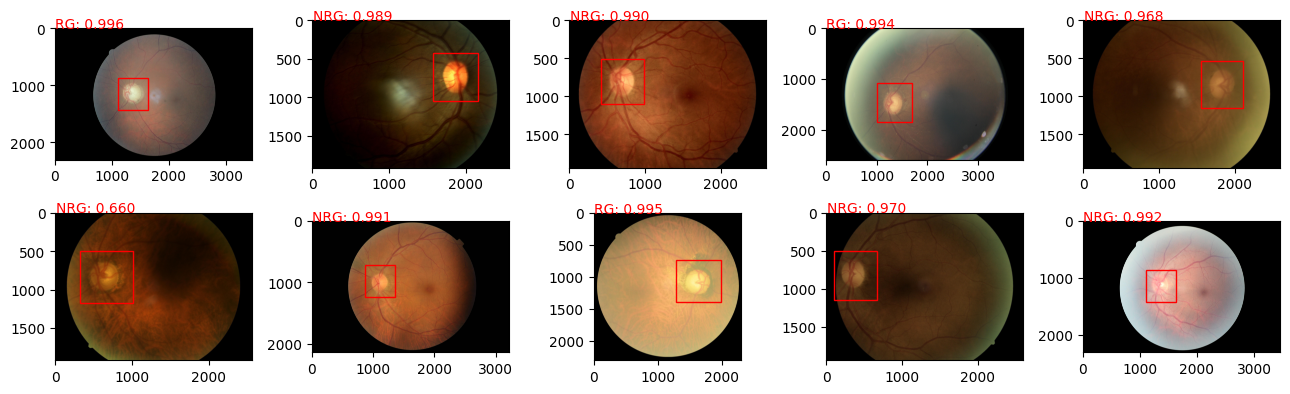

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, axs = plt.subplots(2, 5, figsize=(13, 4))

for i in range(10):
    img_index = i
    boxes, labels, scores = decode_prediction(predictions[img_index])
    max_score_idx = np.argmax(scores)
    label = labels[max_score_idx].item()
    score = scores[max_score_idx]

    ax = axs[i // 5, i % 5]
    ax.imshow(images[img_index].permute(1, 2, 0).numpy())
    ax.text(10, -3, "{}: {:.3f}".format(reverse_label_dict[label], score), color="r")

    # Adicionar caixas delimitadoras
    for box in boxes:
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], 
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

plt.tight_layout()
plt.show()


In [ ]:
Métricas
https://colab.research.google.com/github/vitalfedorov/ML_Notes/blob/master/Metrics.ipynb

In [ ]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_auc_score
from sklearn.datasets import load_breast_cancer
from sklearn import metrics

import matplotlib.pyplot as plt

In [ ]:
def calc_tfpn(y_true, y_pred):
  tp = 0 # true positive
  tn = 0 # true negative
  fp = 0 # false positive
  fn = 0 # false negative

  for i in range(len(y_true)):
    if y_true[i] == y_pred[i] == 1:
      tp += 1
    if y_true[i] == y_pred[i] == 0:
      tn += 1
    if y_true[i] == 1 and y_true[i] != y_pred[i]:
      fp += 1
    if y_true[i] == 0 and y_true[i] != y_pred[i]:
      fn += 1  
  return tp, tn, fp, fn

def best_thresold(y_true, y_pred):
  best_thresh = 0
  best_score = 0
  scores = []
  for i in np.arange(0.1, 1.0, 0.01):
    score = f1_score(y_true, np.array(y_pred) > i)
    scores.append(score)
    if score > best_score:
      best_thresh = i
      best_score = score
  return best_thresh, scores

def best_thresold_beta(y_true, y_pred, beta=0.1):
  best_thresh = 0
  best_score = 0
  scores = []
  for i in np.arange(0.1, 1.0, 0.01):
    score = fbeta_score(y_true, np.array(y_pred) > i, beta=beta)
    scores.append(score)
    if score > best_score:
      best_thresh = i
      best_score = score
  return best_thresh, scores

def my_roc_curve(y_true, y_pred):
  desc_score_indices = np.argsort(y_pred, kind="mergesort")[::-1]
  y_pred_desc = y_pred[desc_score_indices]
  y_true_desc = y_true[desc_score_indices]
  distinct_value_indices = np.where(np.diff(y_pred_desc))[0]
  threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]

  tps = np.cumsum(y_true_desc * 1)[threshold_idxs]
  fps = 1 + threshold_idxs - tps

  tps = np.r_[0, tps]
  fps = np.r_[0, fps]

  fpr = fps / fps[-1]
  tpr = tps / tps[-1]

  return fpr, tpr, y_pred[threshold_idxs]

### Recall (Sensitivity) or True Positive Rate (TPR)
Recall is a valid choice of evaluation metric when we want to capture as many positives as possible. For example: If we are building a system to predict if a person has cancer or not, we want to capture the disease even if we are not very sure.  

\begin{equation*}
TRP = \frac{TP}{TP + FN}
\end{equation*}

With increase of FN, TRP will decline. If FN=0, TRP=1. We don't care about FP.
### Precision or Positive Predictive Value (PPV)
Precision is a valid choice of evaluation metric when we want to be very sure of our prediction. For example: If we are building a system to predict if we should decrease the credit limit on a particular account, we want to be very sure about our prediction or it may result in customer dissatisfaction. 

\begin{equation*}
PPV = \frac{TP}{TP + FP}
\end{equation*}

With increse of FP, PPV will decline. If FP=0, PPV=1
### Accuracy (ACC)
Accuracy is a valid choice of evaluation for classification problems which are well balanced and not skewed or No class imbalance. 

\begin{equation*}
PPV = \frac{TP + TN}{TP + TN + FP + FN}
\end{equation*}

Accuracy simply means the percentage of correct observations.
### F1 score
It’s the harmonic mean between precision and recall.
\begin{equation*}
F_1 = 2*\frac{Precision * Recall}{Precision + Recall}
\end{equation*}

### F1 score with Beta
When choosing beta in your F-beta score the more you care about recall over precision the higher beta you should choose.
\begin{equation*}
F_1 = (1+\beta^2)*\frac{Precision * Recall}{(\beta^2*Precision) + Recall}
\end{equation*}

In [ ]:
tp, tn, fp, fn = calc_tfpn(y_true, y_pred)

print('True Positive (TP): {}'.format(tp))
print('True Negative (TN): {}'.format(tn))
print('False Positive (FP): {}'.format(fp))
print('False Negative (FN): {}'.format(fn))

True Positive (TP): 37
True Negative (TN): 49
False Positive (FP): 9
False Negative (FN): 5


In [ ]:
# Recall (Sensitivity) or True Positive Rate (TPR)
# TPR = TP / (TP + FN)
tpr = tp / (tp + fn)

# Precision or Positive Predictive Value (PPV)
# PPV = TP / (TP + FP) 
ppv = tp / (tp + fp)

# Specificity or Selectivity or True Negative Rate (TNR)
tnr = tn / (tn + fp)

# Accuracy (ACC)
acc = (tp + tn) / (tp + tn + fp + fn)

# F1 score
f1 = 2 * (ppv * tpr) / (ppv + tpr)

In [ ]:
print("Recall (TPR): {:.2f}".format(tpr))
print('Precision (PPV): {:.2f}'.format(ppv))
print('Specificity (TNR): {:.2f}'.format(tnr))
print('Accuracy (ACC): {:.2f}'.format(acc))
print('F1 score (F1): {:.4f}'.format(f1))

Recall (TPR): 0.88
Precision (PPV): 0.80
Specificity (TNR): 0.84
Accuracy (ACC): 0.86
F1 score (F1): 0.8409
